# Arboles de clasificación
Para la clasificación se toman en cuenta las siguientes medidas para evaluar cada division, similar al _RSS_

1. Tasa de error de clasificación (Classification error rate)

$$CER=1-max(\hat{p}_{jk})$$
Donde $\hat{p}_{jk}$ es la proporción de observaciones de la clase j en el nodo k.

2. Indice de Gini

$$GI=\sum_{j=1}^J \hat{p}_{jk} (1- \hat{p}_{jk}) $$

3. Chi cuadrado

$$\chi^2=\sum_{j=1}^J \frac{(Observado_j-Esperado_j)^2}{Esperado_j}$$

4. Entropia cruzada (Cross Entropy)

$$D=-\sum_{j=1}^J \hat{p}_{jk} \ln(\hat{p}_{jk})$$


El proceso de construcción se hace en los siguientes pasos:

1. Para cada división se calcula la medida predefinida

2. Se calcula el valor

$$\frac{n_A\times m_A + n_B \times m_B}{n}$$

3. Se selecciona la divisón que tenga el mejor valor de la medida del paso 2

4. Al finalizar la construcción del arbol se calcula la deviance total como

$$Deviance=-2\sum_{j=1}^J \sum_{k=1}^K n_{jk}\ln (\hat{p}_{jk})$$
y la _residual mean deviance_ como $Deviance/(n-K)$



In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.model_selection import GridSearchCV


In [6]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Cancer.csv"
cancer=pd.read_csv(url, sep=";", index_col=0)
Y=cancer["Tipo"]
X=cancer.drop("Tipo", axis=1)
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2)
X_train.shape

(455, 30)

# Arbol de clasificación

[Acá](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

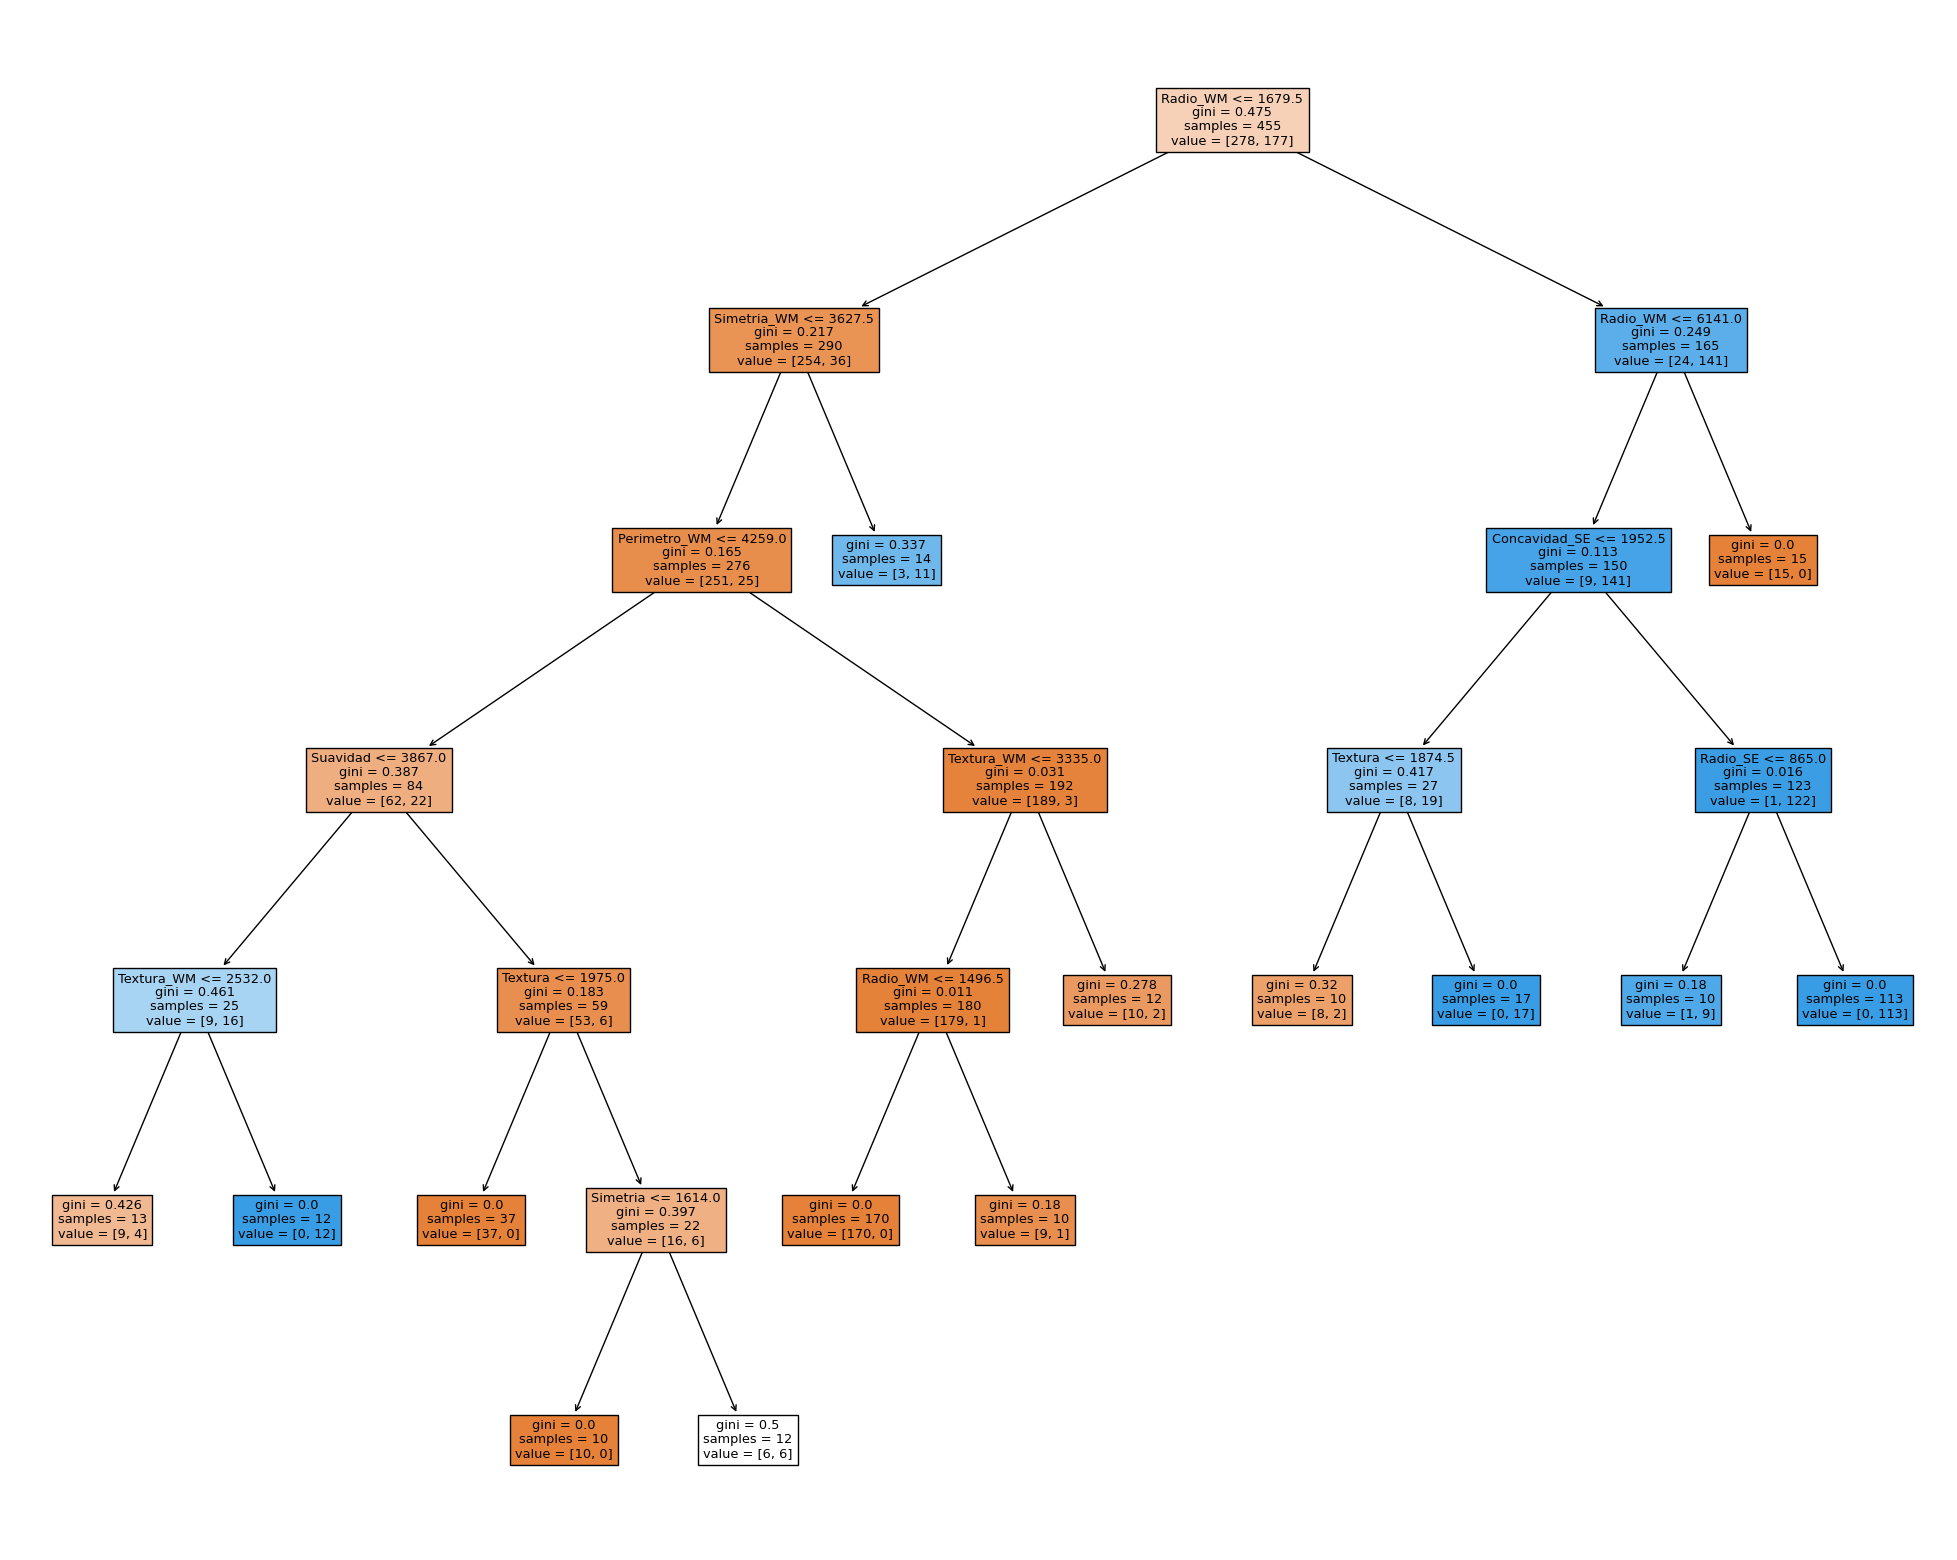

In [7]:
## Construcción del arbol
#Si encuenta minimo 20 divida, pero si es mas pequeño pare, y la hoja va atener minimo 10

arbol=DecisionTreeClassifier(criterion="gini", min_samples_split=20, min_samples_leaf=10)

arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(arbol, feature_names=X_train.columns, filled=True)

# Matriz de confusión

In [1]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

NameError: name 'arbol' is not defined

# Metricas de evaluación de un árbol

Las métricas estan [acá](https://scikit-learn.org/stable/modules/model_evaluation.html) 

1. Accuracy 
$$Acc=\frac{VP+VN}{n}$$

2. Balanced Accuracy

$$BAcc=\frac{1}{2}\left(\frac{VP}{VP+FN}+\frac{VN}{VN+FP} \right)$$

3. Precision
$$Prec=\frac{VP}{VP+FP}$$

4. Recall
$$Recall=\frac{VP}{VP+FN}$$

5. F1-score

$$F_1=\frac{2 (precision \times recall) }{precision + recall}$$

6. F-score

$$F_\beta=(1+\beta^2)\frac{(precision \times recall) }{\beta^2 precision + recall}$$

$$F_\beta=\frac{(1+\beta^2)VP }{(1+\beta^2)VP+
 \beta^2 FN +FP}$$

Generalmente $\beta=2$ o $\beta=1$ [Click](https://en.wikipedia.org/wiki/F-score)

# Podando con la profundidad


In [8]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(3,20),
              'random_state':[0,2,4],
              'criterion':['gini','entropy']} ### voy a probar desde 3 hasta 20 (Diccionario)
arbol= GridSearchCV(DecisionTreeClassifier(), parameters,scoring="accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

0.9120879120879121 {'criterion': 'entropy', 'max_depth': 6, 'random_state': 0}


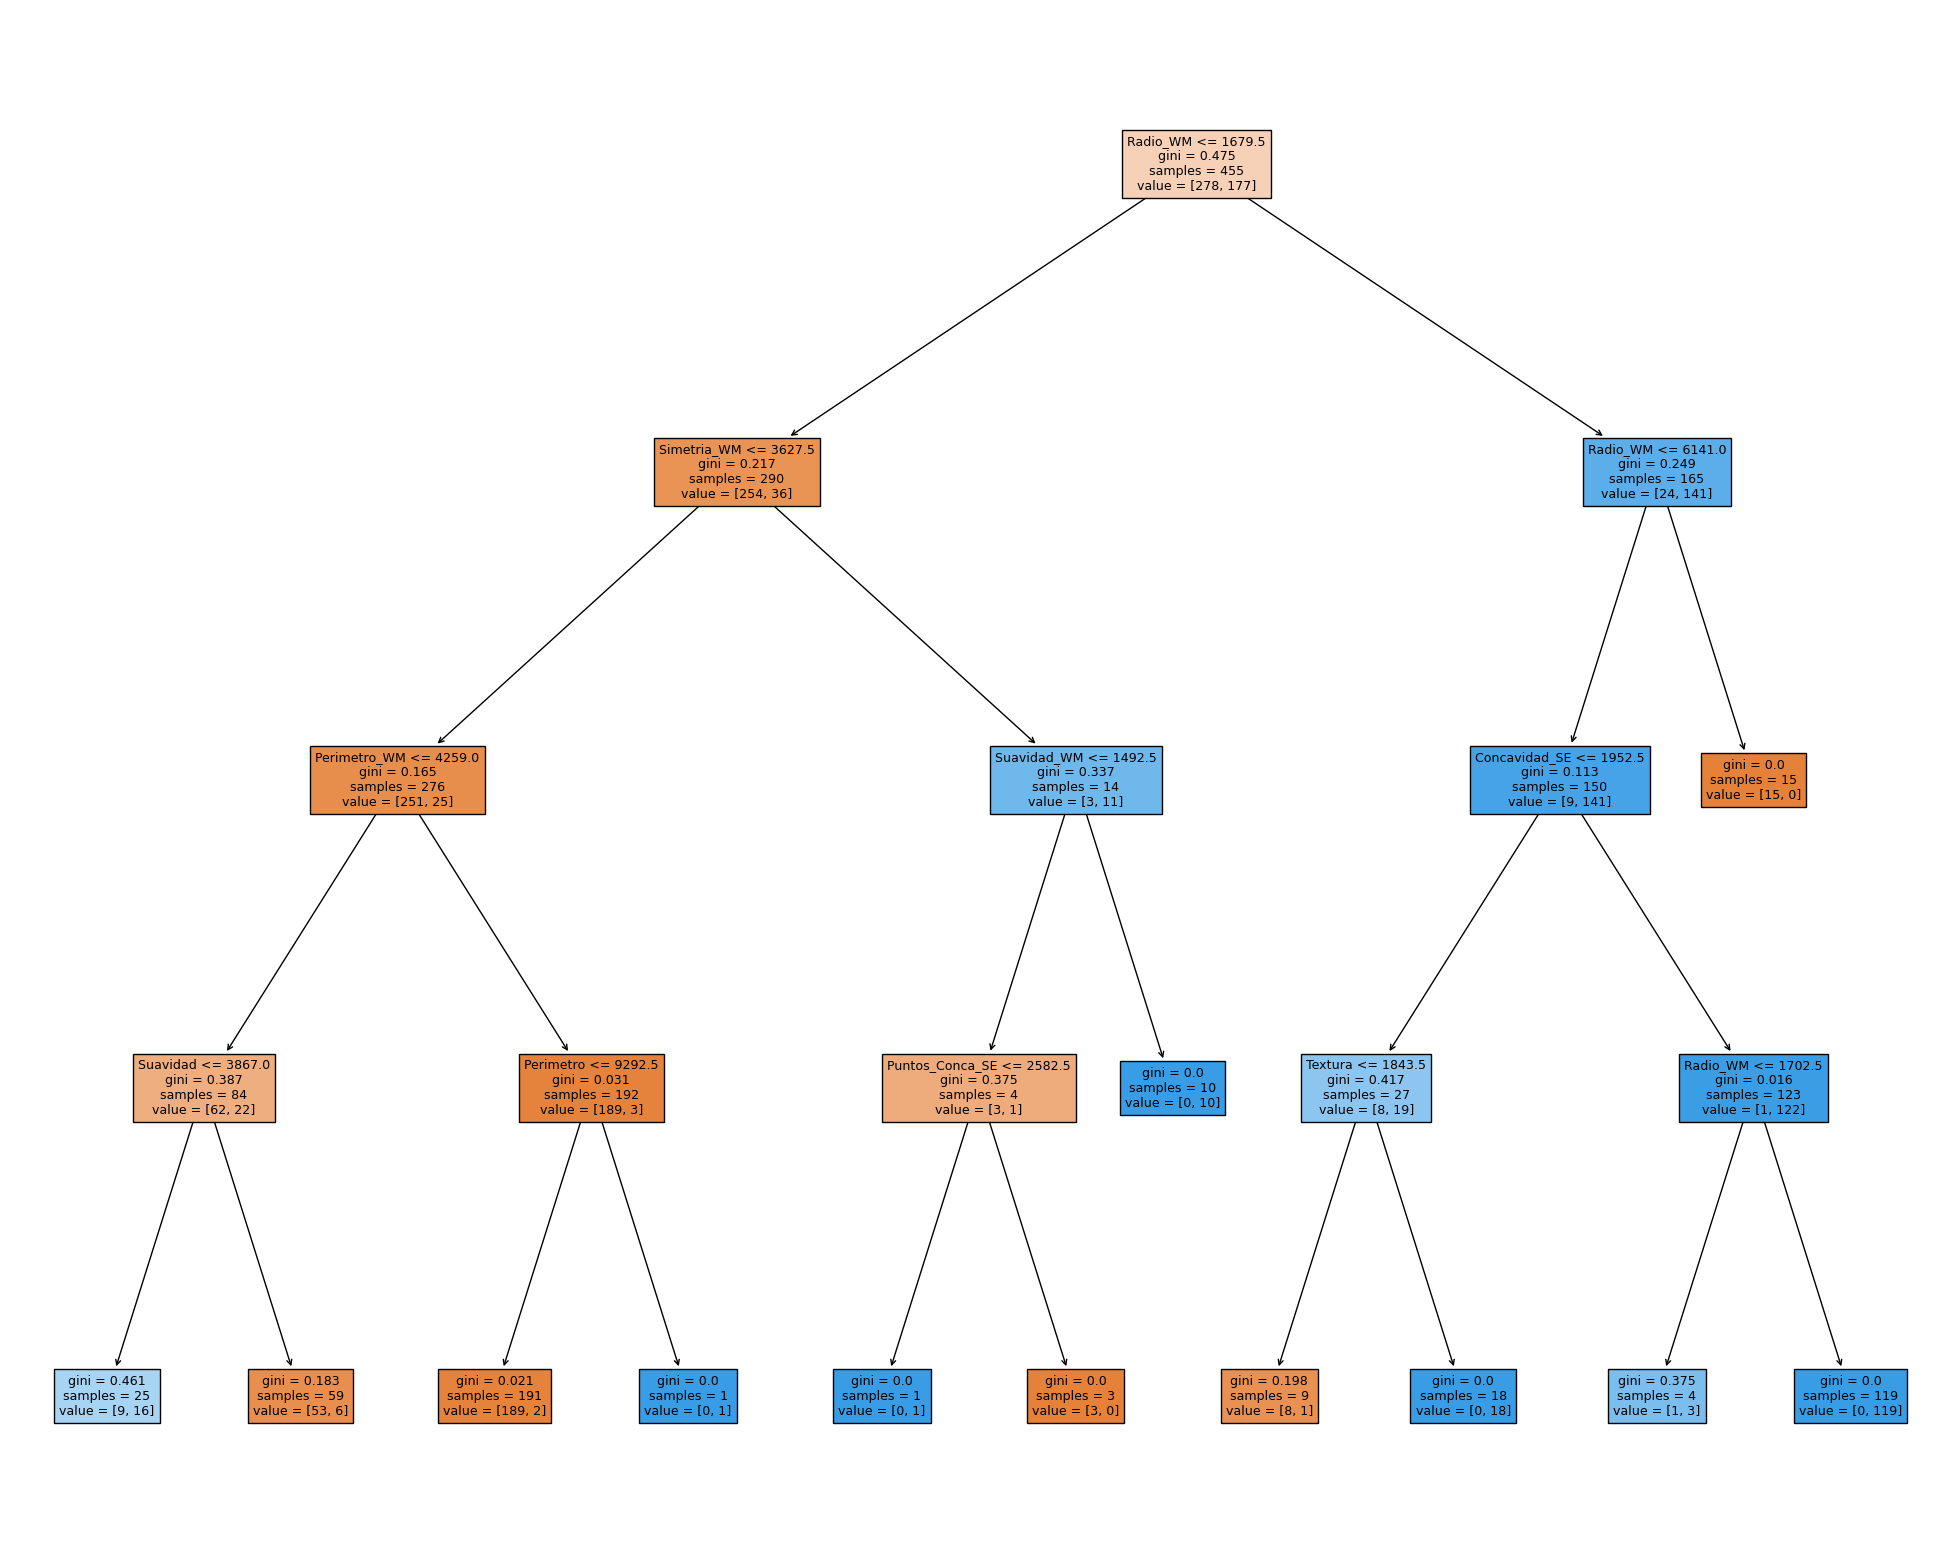

In [9]:
arbol=DecisionTreeClassifier(criterion="gini", max_depth=4)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [11]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[73,  6],
       [ 7, 28]], dtype=int64)

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.91      0.92      0.92        79
           M       0.82      0.80      0.81        35

    accuracy                           0.89       114
   macro avg       0.87      0.86      0.86       114
weighted avg       0.89      0.89      0.89       114



In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8859649122807017

In [14]:
from sklearn.metrics import recall_score
recall_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred, drop_first=True))

0.8

In [15]:
from sklearn.metrics import precision_score
precision_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred, drop_first=True))

0.8235294117647058

In [16]:
from sklearn.metrics import f1_score
f1_score(pd.get_dummies(y_test, drop_first=True), pd.get_dummies(y_pred, drop_first=True))

0.8115942028985507

# Podando con $\alpha$


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

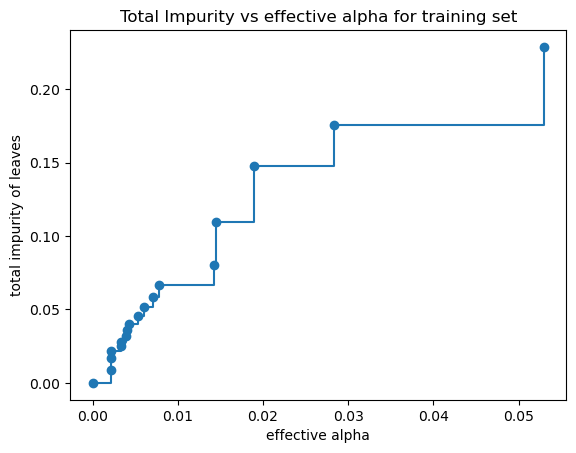

In [17]:
arbol = DecisionTreeClassifier(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

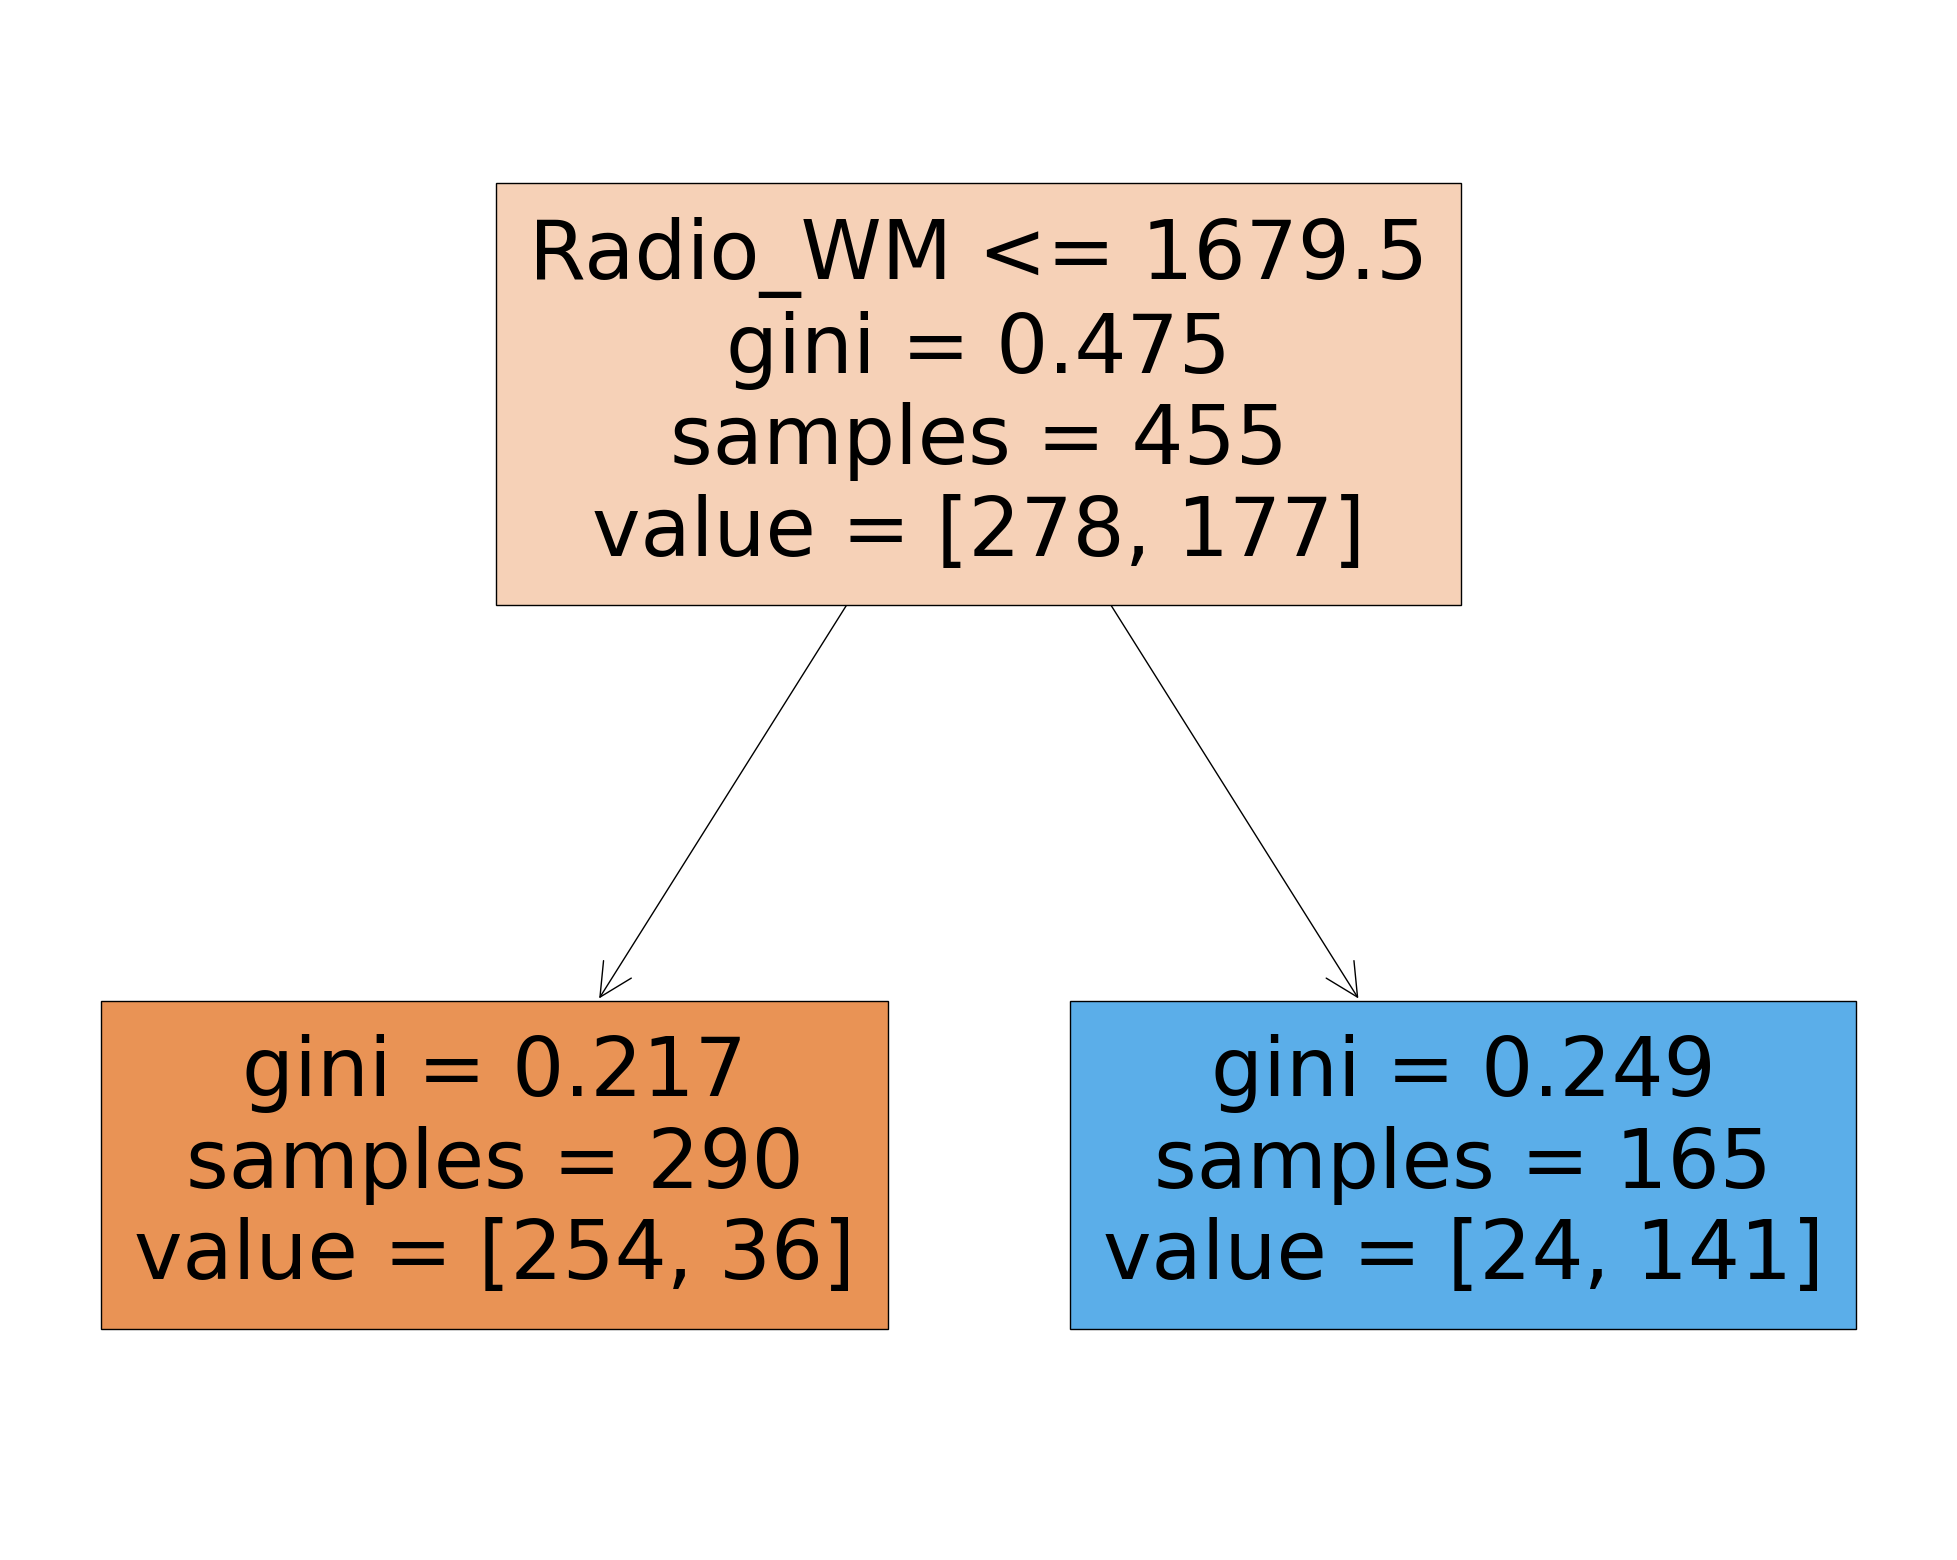

In [32]:
arbol=DecisionTreeClassifier(criterion="gini",ccp_alpha=0.2)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [31]:
pd.DataFrame(arbol.predict_proba(X_test)).value_count()


AttributeError: 'DataFrame' object has no attribute 'value_count'

In [26]:
tree_model.classes_

array(['B', 'M'], dtype=object)

In [ ]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Base de Spam

In [ ]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/spam.csv"
email=pd.read_csv(url, sep=";", decimal=",")
email

In [ ]:
email.groupby(["spam"]).size()

In [ ]:
Y=email["spam"].astype(str) ### Volver a Y cualitativa
X=email.drop(["spam", "time"], axis=1)
X=pd.get_dummies(X, drop_first=True) 
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, stratify=Y)
X_train.shape

In [ ]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=4)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [ ]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

In [ ]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=7)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [ ]:
y_pred=arbol.predict(X_test)
confusion_matrix(y_test, y_pred)

## Problema
Como hay pocos datos de spam, entonces el modelo se ajusta muy mal a elegir un correo como Spam.

Dos soluciones:
1. Aumentar datos, lo cual es muy usado en imagenes
2. Reducir datos en la categoria más grande

# Tarea
Seleccione una muestra de 367 datos no Spam y unala a los 367 datos de spam y construya el árbol y evalue las métricas 

In [ ]:
NoSpam=email[email["spam"]==0]
Spam=email[email["spam"]==1]
SampleNoS=NoSpam.sample(n=Spam.shape[0])
Base=pd.concat([Spam, SampleNoS])
Base.groupby("spam").size()

In [ ]:
Y=Base["spam"].astype(str) ### Volver a Y cualitativa
X=Base.drop(["spam", "time"], axis=1)
X=pd.get_dummies(X, drop_first=True) 
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, stratify=Y)

In [ ]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

In [ ]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=3)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [ ]:
from sklearn.metrics import classification_report
y_pred=arbol.predict(X_test)
print(classification_report(y_test, y_pred))

# Tarea,
Encontrar el "mejor" arbol para clasificar la clase del vino

In [ ]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Vino.csv"
vino=pd.read_csv(url, sep=";", decimal=",")
vino

In [ ]:
Y=vino["Class"]### Volver a Y cualitativa
X=vino.drop(["Class"], axis=1)
X=pd.get_dummies(X, drop_first=True) 
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, stratify=Y)

In [ ]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="accuracy", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

In [ ]:
arbol = tree.DecisionTreeClassifier(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
## Construcción del arbol
arbol=tree.DecisionTreeClassifier(criterion="gini", ccp_alpha=0.03)
arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [ ]:
y_pred=arbol.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
arbol.predict(X_test) ## Predice la clase 

In [ ]:
arbol.predict_proba(X_test) ## Predice la probabilidad de cada clase